In [1]:
from __future__ import division
import warnings
import string

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [2]:
# Information about the data is here: http://anthology.aclweb.org/H/H93/H93-1005.pdf
# feature descriptions: http://www.cs.columbia.edu/~djhsu/coms4721-s16/project/field_types.txt

In [3]:
task = pd.read_csv('../data/data.csv')
quiz = pd.read_csv('../data/quiz.csv')

In [4]:
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Preprocessing

#### Rename the columns to make them easier to work with

In [5]:
alphabet = list(string.ascii_lowercase)
alphabet2 = alphabet + [l+l for l in alphabet] + ['aaa']

In [6]:
task.columns = alphabet2
quiz.columns = alphabet2[:-1]

#### Create useful column subsets

In [7]:
paired_cols = [
    ['a', 'f', 'k'],
    ['b', 'g', 'l'],
    ['c', 'h', 'm'],
    ['d', 'i', 'n'],
    ['e', 'j', 'o'],
    ['ss', 'tt', 'uu']
]

categorical_cols = [
    'a', 'c', 'd', 'e',
    'f', 'h', 'i', 'j',
    'k', 'l', 'n', 'm',
    'o', 'ss', 'tt', 'uu'
] # 'm',

three_value_cols = [
    'aa', 'bb', 'cc',
    'dd', 'ee', 'ff',
    'gg', 'hh', 'ii',
    'jj', 'kk', 'll',
    'mm', 'nn'
]

boolean_cols = [
    'p', 'q',  's',
    'v', 'w',
    'y', 'z', 'oo',
    'pp', 'qq', 'rr', 
    'xx', 'yy', 'zz'
] #     't', 'u', 'r', 'x',

potentially_useless_cols = [
    'x', 'u', 't', 'r'
]

continuous_cols = [
    'vv', 'ww'
]

#### Column Descriptions
- Data From: THE HCRC MAP TASK CORPUS: NATURAL DIALOGUE FOR SPEECH RECOGNITION 
- The corpus is composed of 128 two-person conversations
- The data is an orthographic transcription
- value of the dataset: "Examples supporting this claim are given, including preliminary evidence of the phonetic consequences of second mention and the impact of different styles of referent negotiation on communicative efficacy."
- In particular, maps and feature names were designed to allow for controlled exploration of phonological reductions of various kinds in a number of different referential contexts, and to provide a range of different stimuli to referent negotiation, based on matches and mis-matches between the two maps.
- __The task was for the participant without the route to draw one on the basis of discussion with the participant with the route.__
- 150,000 word tokens, 2000 word types.  __IDEA:__ We should see if there are columns that wehn tokenized add to 150,000.  There might be words that are highly correlated with the outcome type.
- __QUESTION__: What are the outcomes?  If we can figure that out, it might give us ideas for how to determine which features are most relevant. 
- __QUESTION__: what are f 'accent diagnosis' utterances?
- The transcriptions are at the orthographic level, quito detailed, including filled pauses, false starts and repetitions, broken words, 26 etc. 

#### Observations
- There seem to be 'part of speech' columns
- There are a number of columns that only take on the values 0, 1, or 2.  They could be counts?
- There are a number of boolean columns where there are very few 1s
- __IDEA__: Can we use the token information to determine which colums are the eye contact ones?
- __IDEA__: Are the 0,1,2 codes for None, Definite, Indefinite?
- __QUESTION:__ which are the eye contact and familiarity columns?
- uu and m have the most possible values

#### Column Findings
 - columns d and i are the the roles (Intruction Follower or Giver) and n is the sequence  
 - columnds d,e,f and i,j,k have the same possible values

### Data Checks and Cleaning

In [8]:
# Null Values
# task.count()

In [9]:
# task = task.drop_duplicates().reset_index()

### Feature Creation

#### One-hot encoding of the columns

In [10]:
final_cols = categorical_cols + three_value_cols + boolean_cols + continuous_cols

In [11]:
X_dummies = pd.get_dummies(task[final_cols])

In [12]:
X_quiz_dummies = pd.get_dummies(quiz[final_cols])

In [13]:
X_train_dummies = X_dummies[[col for col in X_dummies.columns if col in X_quiz_dummies.columns]]

In [14]:
X_quiz_dummies = X_quiz_dummies[[col for col in X_quiz_dummies.columns if col in X_train_dummies.columns]]

In [15]:
X_train_sample = X_train_dummies.sample(10000)

In [16]:
target_cols = [col for col in X_dummies.columns if col in X_quiz_dummies.columns]

In [17]:
sample_ixs = list(X_train_sample.index)

In [18]:
y = task.aaa.as_matrix()
y_sample = y[sample_ixs]

#### Transformation of the Distribution of the Continuous Columns

In [49]:
# from sklearn.preprocessing import FunctionTransformer
# task.ww[task.ww > 10].apply(np.log)
# task.vv[task.vv > 10].apply(np.log)

#### Polynomial Feature Expansion

In [29]:
from sklearn.preprocessing import PolynomialFeatures

In [79]:
X_poly = PolynomialFeatures(interaction_only=True).fit_transform(X)

### Feature Selection

#### Dropping redundant columns

In [30]:
from sklearn.feature_selection import VarianceThreshold
# TODO: # Find correlated features and drop them
# task.drop(potentially_useless_cols, inplace=True)
# sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
# X_reduced = sel.fit_transform(X_dummies)

#### Recursive feature elemination

In [31]:
# from sklearn.feature_selection import RFE
# svc = SVC(kernel="linear", C=1)
# rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
# rfe.fit(X, y)
# ranking = rfe.ranking_.reshape(digits.images[0].shape)

#### Select K Best

In [32]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [33]:
# X_new = SelectKBest(chi2, k=1000).fit_transform(X_, y)

#### Models Scoring Feature Selection (SelectFromModel)

In [19]:
from sklearn.cross_validation import train_test_split

In [20]:
from sklearn.feature_selection import SelectFromModel

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
rf_clf = RandomForestClassifier(n_estimators=30, n_jobs=-1)

In [23]:
# X = SelectFromModel(rf_clf).fit_transform(X_train_sample.as_matrix(), y=y)

#### Custom Model Scoring Feature Selection

In [24]:
def score_features(clf, X, y, n_iterations=1):
    rankings = []
    for it in range(n_iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        rf_clf.fit(X, y)
        rankings.append(clf.feature_importances_)
    return np.array(rankings)

In [25]:
feats = score_features(rf_clf, X_train_sample.as_matrix(), y_sample, n_iterations=20)

In [ ]:
# featss = pd.Series(feats.sum(axis=0))

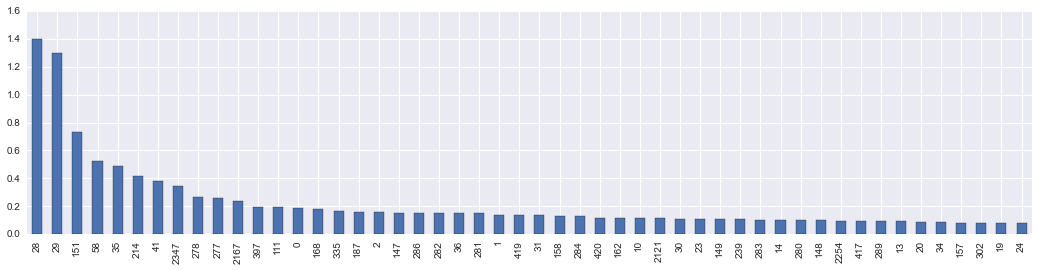

In [32]:
pd.Series(feats.sum(axis=0)).order(ascending=False).iloc[:50].plot(kind='bar', figsize=(18,4))

In [26]:
imp_sums = pd.Series(feats.sum(axis=0))

In [27]:
gt_zero_features = imp_sums[imp_sums > 0].index

In [28]:
best_features = list(pd.Series(feats.sum(axis=0)).order(ascending=False).iloc[:100].index)

In [29]:
best_cols = X_train_dummies.columns[best_features]

In [30]:
gt_zero_cols = X_train_dummies.columns[gt_zero_features]

In [31]:
# What is this?
# X_train_sample.reset_index()
# X = X_train_sample[X_train_sample[best_cols[:100]].mean(axis=1) > .25]

In [32]:
# X_train_sample.ix[ws, best_cols[:100]]
# new_x = X_train_sample.reset_index().drop('index', 1)

### Testing the Estimators

In [36]:
X = X_train_dummies[gt_zero_cols]

In [37]:
X.shape

(126837, 2240)

##### KNN

In [129]:
from sklearn.neighbors import KNeighborsClassifier

In [130]:
# Tuning options: distance metric and size of k
knn_clf = KNeighborsClassifier()

##### Discriminant Analysis

In [240]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [241]:
lda_clf = LinearDiscriminantAnalysis(store_covariance=True)
qda_clf = QuadraticDiscriminantAnalysis(store_covariances=True)

##### Ensemble Methods

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

In [42]:
rf_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1)

In [43]:
et_clf = ExtraTreesClassifier(n_estimators=200, n_jobs=-1)

In [44]:
gb_clf = GradientBoostingClassifier(n_estimators=200)

In [245]:
e_clf = VotingClassifier(estimators=[('rf', rf_clf), ('et', et_clf), ('gb', gb_clf)], voting='hard')

##### SVMs

In [246]:
from sklearn import svm

In [247]:
# Tuning options: choice of kernel, size of C, size of gamma, size of degree
C = .5  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C)
rbf_svc = svm.SVC(kernel='rbf', gamma='auto', C=C)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C)
lin_svc = svm.LinearSVC(C=C)
# sgd = svm.SGDClassifier(n_iter=100, alpha=0.01)

#### Cross Validation

In [248]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score

##### KNN

In [253]:
# cv_scores = cross_val_score(knn_clf, X, y, cv=3)
# cv_scores

#### Discriminant Analysis


In [254]:
from sklearn import preprocessing

In [ ]:
X_scaled = preprocessing.scale(X)

In [143]:
cv_scores = cross_val_score(qda_clf, X_scaled, y_sample, cv=3)
cv_scores

array([ 0.68694504,  0.61550462,  0.53618145])

In [ ]:
cv_scores = cross_val_score(lda_clf, X_scaled, y_sample, cv=3)
cv_scores

##### Ensemble methods

In [145]:
cv_scores = cross_val_score(rf_clf, X, y_sample, cv=3)
cv_scores

array([ 0.89416847,  0.8925957 ,  0.88539542])

In [146]:
cv_scores = cross_val_score(et_clf, X, y_sample, cv=3)
cv_scores

array([ 0.88816895,  0.88227529,  0.88071523])

In [147]:
cv_scores = cross_val_score(gb_clf, X, y_sample, cv=3)
cv_scores

array([ 0.89356851,  0.89151566,  0.88527541])

In [ ]:
cv_scores = cross_val_score(e_clf, X, y_sample, cv=3)
cv_scores

In [38]:
rf_clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
# X_quiz_dummies[gt_zero_cols].shape

(31709, 2240)

In [39]:
preds = rf_clf.predict(X_quiz_dummies[gt_zero_cols].as_matrix())

In [95]:
# pred = pd.DataFrame(preds).reset_index()
# pred.columns = ['Id', 'Prediction']
# pred.Id = pred.Id + 1
# pred.to_csv('../data/pred5.csv', index=False)

##### SVM

In [150]:
# cv_scores = cross_val_score(svc, X, y_sample, cv=3)
# cv_scores

In [151]:
cv_scores = cross_val_score(rbf_svc, X_scaled, y_sample, cv=3)
cv_scores

array([ 0.88612911,  0.87915517,  0.87831513])

In [ ]:
cv_scores = cross_val_score(poly_svc, X, y_sample, cv=3)
cv_scores

#### Iterative CV Scores

In [31]:
rf_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1)

In [85]:
def iterative_cv_scores(clf, X, y, n_iterations=1):
    n_iterations = 5
    scores = []
    for ix in range(n_iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        score = clf.fit(X_train, y_train).score(X_test, y_test)
        scores.append(score)
    return scores

In [87]:
iter_scores = iterative_cv_scores(rf_clf, X, y_sample, n_iterations=10)

#### K-Fold

In [43]:
kf = KFold(n=X_train_dummies.shape[0]-1, n_folds=6, shuffle=False, random_state=None)

In [44]:
def kfold_cv_scores(clf, X, y, kf):
    scores = []
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        score = clf.fit(X_train, y_train).score(X_test, y_test)
        scores.append(score)
    print scores

### Diagnostics

In [152]:
X = X_train_dummies[best_cols].as_matrix()

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [155]:
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

In [157]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split

In [158]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])

In [159]:
# fpr, tpr, _ = roc_curve(y_test, lda_clf.predict_proba(X_test)[:,1])

ROC AUC: 0.94


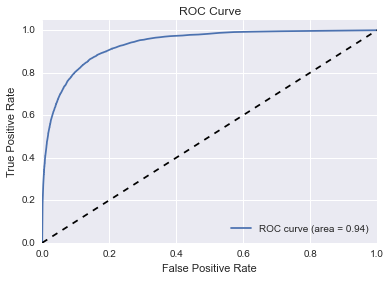

In [160]:
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print 'ROC AUC: %0.2f' % roc_auc
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### Confusion Matrix

In [161]:
from sklearn.metrics import confusion_matrix

In [162]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [163]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

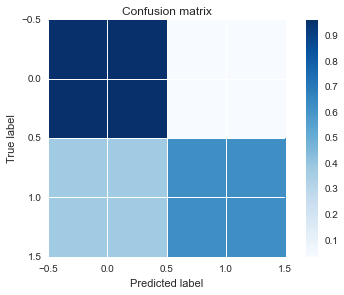

In [164]:
plot_confusion_matrix(cm_normalized)

#### Classification Report

In [166]:
from sklearn.metrics import classification_report

In [167]:
# Precision is higher for 1 than -1
# Recall is higher for -1 than for 1
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

         -1       0.92      0.96      0.94     20359
          1       0.80      0.62      0.70      4625

avg / total       0.90      0.90      0.90     24984



#### identifying the incorrectly classified data points

In [145]:
def misclassified_counts(clf, X, y, n_iterations=1):
    """ Creates a matrix of classification outcomes """
    fps = []
    fns = []
    tps = []
    tns = []
    preds = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=33)
    for it in range(n_iterations):
        rf_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
        rf_clf.fit(X_train, y_train)
        y_preds = rf_clf.predict(X_test)
        pred_df = pd.DataFrame({'true': y_test, 'pred': y_preds })
        fps.append(((pred_df.true==1) & (pred_df.pred==-1)).astype(int).values)
        fns.append(((pred_df.true==-1) & (pred_df.pred==1)).astype(int).values)
        tps.append(((pred_df.true==1) & (pred_df.pred==1)).astype(int).values)
        tns.append(((pred_df.true==-1) & (pred_df.pred==-1)).astype(int).values)
        preds.append((pred_df.true!=pred_df.pred).astype(int).values)
    return (np.array(fps), np.array(fns), np.array(tps), np.array(tns), np.array(preds))

In [146]:
fps, fns, tps, tns, preds = misclassified_counts(rf_clf, X, y_sample, 30)

In [62]:
fpss = pd.Series(fps.sum(axis=0))
tpss = pd.Series(tps.sum(axis=0))
fnss = pd.Series(fns.sum(axis=0))
tnss = pd.Series(tns.sum(axis=0))
predss = pd.Series(np.array(preds).sum(axis=0))
predsdf = pd.DataFrame(preds)

In [64]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_sample, test_size=0.4, random_state=33)

In [65]:
# rf_clf.fit(X_train, y_train).score(X_test, y_test)

In [148]:
wrong = pd.DataFrame({
    'false_positives': fpss.values, 
    'false_negatives': fnss.values, 
    'total_wrong': (fpss + fnss)
})
wrong['prop_fn'] = wrong.false_negatives / wrong.total_wrong
wrong['prop_fp'] = wrong.false_positives / wrong.total_wrong

In [149]:
fpdf = wrong[(wrong.prop_fp > .9) & (wrong.total_wrong > 10)]
fndf = wrong[(wrong.prop_fn > .9) & (wrong.total_wrong > 10)]

In [150]:
fpixs = [ix for ix in range(X_test.shape[0]) if ix not in fpdf.index]
fpixs = [ix for ix in range(X_test.shape[0]) if ix not in fndf.index]

In [151]:
fp25_ix = fpss[fpss > 25].index
tp25_ix = tpss[tpss > 25].index
fn25_ix = fnss[fnss > 25].index
tn25_ix = tnss[tnss > 25].index

In [147]:
# X_train[fp25_ix]
# X_train

#### Error Analysis

In [168]:
X_best_cols = X_train_dummies[best_cols]

In [172]:
sample_sizes = [
    int(rows/1000), int(rows/500), int(rows/250), 
    int(rows/100), int(rows/50), int(rows/10), 
    int(rows/2), rows
]

In [203]:
ticks = [str((s / rows) * 100)[:4] + '%' for s in sample_sizes]

In [169]:
rows = X_train_dummies.shape[0]
sample_sizes = [
    int(rows/1000), int(rows/500), int(rows/250), 
    int(rows/100), int(rows/50), int(rows/10), 
    int(rows/2), rows
]
training_errors = []
test_errors = []
for sample in sample_sizes:
    X = X_best_cols.sample(sample)
    sample_ixs = list(X.index)
    y_sample = y[sample_ixs]
    X_train, X_test, y_train, y_test = train_test_split(X, y_sample, test_size=0.5)
    rf_clf.fit(X_train, y_train)
    train_error = 1 - rf_clf.score(X_train, y_train)
    test_error = 1 - rf_clf.score(X_test, y_test)
    training_errors.append(train_error)
    test_errors.append(test_error)

In [204]:
ticks

['0.09%', '0.19%', '0.39%', '0.99%', '1.99%', '9.99%', '50.0%', '100.%']

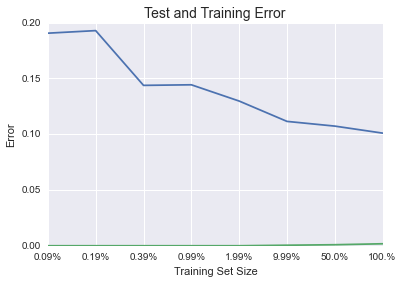

In [210]:
ax = plt.figure()
test_err = pd.Series(test_errors)
train_err = pd.Series(training_errors)
test_err.index = ticks
train_err.index = ticks
test_err.plot()
train_err.plot()
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.title('Test and Training Error', fontsize=14)

#### PCA on the Continuous Columns

In [101]:
from sklearn.decomposition import PCA

In [131]:
pca = PCA(n_components=3, copy=True, whiten=False)

In [132]:
X_pca = X_train[best_cols[:10]].as_matrix()

In [133]:
# X_r = pca.fit(X_pca).transform(X_pca)

In [139]:
# plt.scatter(X_r[:,0], X_r[:,1])

In [124]:
# sns.lmplot(data=X_train[['vv', 'ww']], x='vv', y='ww', x_jitter=.1, y_jitter=.1)

#### Plotting Decision Surface

In [211]:
model = rf_clf

In [212]:
cmap = plt.cm.RdYlBu
plot_step_coarser = 0.5
n_classes = 2

In [141]:
# X = X_train[tp25_ix]

In [217]:
X_cont = X.as_matrix()[:, :2]

# Standardize
mean = X_cont.mean(axis=0)
std = X_cont.std(axis=0)
X_cont = (X_cont - mean) / std

# Train
clf = model.fit(X_cont, y)

In [218]:
x_min, x_max = X_cont[:, 0].min() - 1, X_cont[:, 0].max() + 1
y_min, y_max = X_cont[:, 1].min() - 1, X_cont[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .2),
                     np.arange(y_min, y_max, .2))

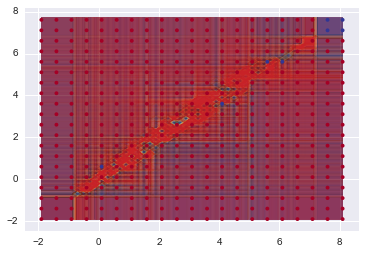

In [219]:
estimator_alpha = 1.0 / len(model.estimators_)
for tree in model.estimators_:
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)
    
xx_coarser, yy_coarser = np.meshgrid(np.arange(x_min, x_max, plot_step_coarser),
                                     np.arange(y_min, y_max, plot_step_coarser))
Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(), yy_coarser.ravel()]).reshape(xx_coarser.shape)
cs_points = plt.scatter(xx_coarser, yy_coarser, s=15, c=Z_points_coarser, cmap=cmap, edgecolors="none")

In [ ]:
# Plot the training points, these are clustered together and have a
# black outline
# classes = ['-1', '1']
# for i, c in zip(xrange(n_classes), plot_colors):
#     idx = np.where(y == i)
#     plt.scatter(X[idx, 0], X[idx, 1], c=c, label=classes[i],
#                 cmap=cmap)

#### MDS

In [42]:
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

In [ ]:
# X = X_train_sample[best_cols[:20]].ix[:500, 2:].as_matrix()

In [77]:
similarities = euclidean_distances(X)

In [78]:
mds = manifold.MDS(n_components=2, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)

In [80]:
# pos = mds.fit(similarities).embedding_

In [52]:
pos.shape

(100, 2)

In [63]:
posdf = pd.DataFrame(pos, columns= ['x', 'y'])
posdf['label'] = y_test[:100]
posdf['wrong'] = (wrong.total_wrong > 3).astype(int)[:100]

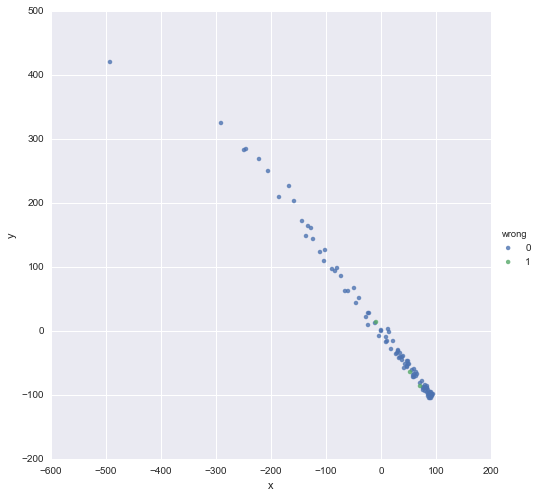

In [64]:
sns.lmplot('x', 'y', posdf, fit_reg=False, hue='wrong', size=7)